In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader  
from skimage import io

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset_2.zip"

Archive:  /content/drive/MyDrive/Dataset_2.zip
   creating: Dataset_2/
  inflating: Dataset_2/t10k-images-idx3-ubyte  
  inflating: Dataset_2/t10k-labels-idx1-ubyte  
  inflating: Dataset_2/train-images-idx3-ubyte  
  inflating: Dataset_2/train-labels-idx1-ubyte  
  inflating: Dataset_2/verification_test.csv  
  inflating: Dataset_2/verification_train.csv  


In [ ]:
train_csv  = pd.read_csv('/content/Dataset_2/verification_train.csv')
test_csv = pd.read_csv('/content/Dataset_2/verification_test.csv')

In [ ]:
import numpy as np
class second_Dataset(Dataset):
  
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.data_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.data_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
train_set = second_Dataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = second_Dataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [ ]:
print(len(train_set))
print(len(test_set))

60000
10000


In [ ]:
# Hyperparameters

batch_size = 20
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 200 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False)





class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_4 = nn.ReLU()

        ### 5th hidden layer: 100 --> 100
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 100 --> 100
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_6 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_3(out)
        
        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_4(out)

        ### 5th hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_5(out)
        
        ### 6th hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_6(out)
     
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration_loss= []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6645278930664062. Accuracy: 78.03
Iteration: 1000. Loss: 0.38071322441101074. Accuracy: 81.04
Iteration: 1500. Loss: 0.9475749135017395. Accuracy: 79.8
Iteration: 2000. Loss: 0.4743714928627014. Accuracy: 83.61
Iteration: 2500. Loss: 0.8186467885971069. Accuracy: 82.44
Iteration: 3000. Loss: 0.2732177972793579. Accuracy: 83.63
Iteration: 3500. Loss: 0.3909406065940857. Accuracy: 84.07
Iteration: 4000. Loss: 0.5882918238639832. Accuracy: 84.25
Iteration: 4500. Loss: 0.1658419668674469. Accuracy: 82.25
Iteration: 5000. Loss: 0.43605130910873413. Accuracy: 85.62
Iteration: 5500. Loss: 0.46216315031051636. Accuracy: 85.84
Iteration: 6000. Loss: 0.5495806932449341. Accuracy: 86.12
Iteration: 6500. Loss: 0.5575653314590454. Accuracy: 85.52
Iteration: 7000. Loss: 0.5201238393783569. Accuracy: 83.98
Iteration: 7500. Loss: 0.3439096510410309. Accuracy: 84.91
Iteration: 8000. Loss: 0.1770702600479126. Accuracy: 87.28
Iteration: 8500. Loss: 0.6627584099769592. Accuracy: 86

[0.6645278930664062, 0.38071322441101074, 0.9475749135017395, 0.4743714928627014, 0.8186467885971069, 0.2732177972793579, 0.3909406065940857, 0.5882918238639832, 0.1658419668674469, 0.43605130910873413, 0.46216315031051636, 0.5495806932449341, 0.5575653314590454, 0.5201238393783569, 0.3439096510410309, 0.1770702600479126, 0.6627584099769592, 0.24270176887512207, 0.4723750054836273, 0.4308520257472992, 0.1637759655714035, 0.41388458013534546, 0.391353577375412, 0.24036721885204315, 0.37093332409858704, 0.6578133702278137, 0.463834285736084, 0.252955824136734, 0.3538977801799774, 0.2781962752342224, 0.6374648809432983, 0.29817286133766174, 0.12351258844137192, 0.3744525909423828, 0.3029823899269104, 0.06428860127925873]


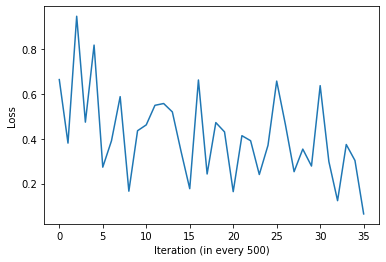

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()